In [1]:
import xgboost as xgb
import joblib    
import pandas as pd
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from utilities.common import merge, compute_metrics, FEATURES

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Config

In [2]:
DATA        = "../data/processed/Training_Data.csv"  
ODDS_DIR    = "../data/raw/bookmakersOdds" 
XGB         = "models/xgboost_fold5.pkl"
RF          = "models/random_forest_fold5.pkl"
LR          = "models/log_reg_fold5.pkl"
DT          = "models/decision_tree_fold5.pkl"

SLAMS = {                                    
    "Australian Open": "AusOpen",     
    "Roland Garros"  : "FrenchOpen",         
    "Wimbledon"      : "Wimbledon",
    "US Open"        : "UsOpen"                   
}

MODELS = [
    'DT', 'LR', 'RF', 'XGB', 'BOOK'
]

STAKE = 10

df = pd.read_csv(DATA, parse_dates=["MATCH_DATE"])

In [3]:
def add_match_probs(data, pipeline, label):

    X = data[pipeline.feature_names_in_]        
    proba = pipeline.predict_proba(X)[:, 1]     

    out = data.copy()
    out[f"{label}_p1"] = proba
    out[f"{label}_p2"] = 1 - proba

    return out

accuracy_log = []

def process_slam(df, slam_name, year):
    sub = df[
        (df['TOURNEY_LEVEL'] == 'G') &
        (df['MATCH_DATE'].dt.year == year) &
        (df['TOURNEY_NAME'] == slam_name)
    ].copy()
    if sub.empty:
        warnings.warn(f"No rows for {slam_name} {year}")
        return None
    
    dt_pipe = joblib.load(DT)
    lr_pipe = joblib.load(LR)
    rf_pipe = joblib.load(RF)
    xgb_pipe = joblib.load(XGB)

    sub = add_match_probs(sub, dt_pipe, 'DT')
    sub = add_match_probs(sub, lr_pipe, 'LR')
    sub = add_match_probs(sub, rf_pipe, 'RF')
    sub = add_match_probs(sub, xgb_pipe, 'XGB')

    y_true = sub["RESULT"]

    m_dt   = compute_metrics(y_true, sub["DT_p1"])
    m_lr   = compute_metrics(y_true, sub["LR_p1"])
    m_rf   = compute_metrics(y_true, sub["RF_p1"])
    m_xgb  = compute_metrics(y_true, sub["XGB_p1"])

    stub   = SLAMS[slam_name]                      
    fname  = f"{stub}_{str(year)[-2:]}.csv"       
    odds_fp = os.path.join(ODDS_DIR, fname)

    try:
        odds_df = pd.read_csv(odds_fp)
    except FileNotFoundError:
        warnings.warn(f"Odds file missing: {odds_fp}")
        return None

    merged = merge(sub, odds_df)
    merged["Odds_p1"] = np.where(merged["RESULT"] == 1, merged["WinOdds"], merged["LoseOdds"])
    merged["Odds_p2"] = np.where(merged["RESULT"] == 1, merged["LoseOdds"], merged["WinOdds"])
    merged.drop(columns=["WinOdds", "LoseOdds"], inplace=True)

    merged['BOOK_p1'] = merged['Odds_p2'] / (merged['Odds_p1'] + merged['Odds_p2'])
    merged['BOOK_p2'] = merged['Odds_p1'] / (merged['Odds_p1'] + merged['Odds_p2'])


    m_book = compute_metrics(y_true, merged["BOOK_p1"])

    accuracy_log.append({
        "Slam"          : slam_name,
        "Year"          : year,
        "Matches"       : len(sub),

        "Accuracy DT"   : m_dt["Acc"],
        "ROC AUC DT"    : m_dt["AUC"],
        "Log Loss DT"   : m_dt["LogL"],
        "Brier DT"      : m_dt["Brier"],

        "Accuracy LR"   : m_lr["Acc"],
        "ROC AUC LR"    : m_lr["AUC"],
        "Log Loss LR"   : m_lr["LogL"],
        "Brier LR"      : m_lr["Brier"],

        "Accuracy RF"   : m_rf["Acc"],
        "ROC AUC RF"    : m_rf["AUC"],
        "Log Loss RF"   : m_rf["LogL"],
        "Brier RF"      : m_rf["Brier"],

        "Accuracy XGB"  : m_xgb["Acc"],
        "ROC AUC XGB"   : m_xgb["AUC"],
        "Log Loss XGB"  : m_xgb["LogL"],
        "Brier XGB"     : m_xgb["Brier"],

        "Accuracy Book" : m_book["Acc"],
        "ROC AUC Book"  : m_book["AUC"],
        "Log Loss Book" : m_book["LogL"],
        "Brier Book"    : m_book["Brier"],
    })



    cols_to_drop = [
        'TOURNEY_LEVEL','SURFACE','DRAW_SIZE','BEST_OF',
        'P1_ID','P2_ID',*FEATURES
    ]

    merged.drop(columns=[c for c in cols_to_drop if c in merged.columns], inplace=True, errors='ignore')

    return merged


def process_all(df, start_year=2010, end_year=2024):
    results = {}
    for year in range(start_year, end_year + 1):
        for slam in SLAMS:
            res = process_slam(df, slam, year)
            if res is not None:
                results[(slam, year)] = res
    return results


## Grand Slams 2010-2024 Accuracy

In [4]:
all_slams = process_all(df, 2010, 2024)

acc_table = pd.DataFrame(accuracy_log).reset_index(drop=True)


metrics = ["Accuracy", "ROC AUC", "Log Loss", "Brier"]
models  = ["DT", "LR", "RF", "XGB", "Book"]

print("\nAverage metrics across all Slams/years:")
for metric in metrics:
    print(f"\n{metric}:")
    for mdl in models:
        mean_val = acc_table[f"{metric} {mdl}"].mean()
        print(f"  {mdl:<5} : {mean_val:.4f}")

/tmp/ipykernel_99108/3976998112.py:21: UserWarning: No rows for Wimbledon 2020
  warnings.warn(f"No rows for {slam_name} {year}")



Average metrics across all Slams/years:

Accuracy:
  DT    : 0.7347
  LR    : 0.7468
  RF    : 0.7642
  XGB   : 0.7518
  Book  : 0.7653

ROC AUC:
  DT    : 0.8138
  LR    : 0.8271
  RF    : 0.8525
  XGB   : 0.8352
  Book  : 0.8452

Log Loss:
  DT    : 0.5283
  LR    : 0.5133
  RF    : 0.4876
  XGB   : 0.5054
  Book  : 0.4888

Brier:
  DT    : 0.1768
  LR    : 0.1712
  RF    : 0.1600
  XGB   : 0.1676
  Book  : 0.1608


## Shorter Price Simulation

In [5]:
def simulate_shorter_price(df, model ,stake=10):

    out = df.copy()

    p1_rank = out["P1_ATP"]  
    p2_rank = out["P2_ATP"]

    def pick(prob1, prob2):

        p1_better = prob1 > prob2
        p2_better = prob1 < prob2

        undecided = ~(p1_better | p2_better)
        rank_tiebreak = p1_rank < p2_rank   

        return np.where(undecided, rank_tiebreak, p1_better)

    bet = pick(out[f"{model}_p1"], out[f"{model}_p2"])

    odds = np.where(bet, out['Odds_p1'], out['Odds_p2'])

    win = np.where(bet,  out["RESULT"] == 1, out["RESULT"] == 0)
    
    profit = np.where(win,  stake * (odds  - 1), -stake)

    total_bets = bet.sum()
    total_stake = total_bets * stake
    total_profit = profit.sum()
    roi = total_profit / total_stake

    summary = {
        f'{model}_profit'   : profit.sum(),
    }

    return summary

### Simulate a single slam

In [6]:
# simulate_shorter_price(all_slams[("Roland Garros", 2021)], 10)

In [7]:
records = []
total_matches = 0

for (slam, yr), df in all_slams.items():
    total_matches += len(df)
    row = {
        "Slam"  : slam,
        "Year"  : yr,
        }

    for model in MODELS:
        summary = simulate_shorter_price(df, model, STAKE)
        row[f"{model}_net"] = summary[f'{model}_profit']

    records.append(row)
    
summary = pd.DataFrame(records)
overall = summary[["DT_net","LR_net", 'RF_net', 'XGB_net', 'BOOK_net']].sum()

for model in MODELS:
    profit = overall[f"{model}_net"]
    overall[f"{model}_roi"] = profit / (STAKE * total_matches)


print(f"TOTAL 2010-2024 (all Grand Slams) across {total_matches} matches(STAKE: {STAKE}):\n")
for model in MODELS:
    print(f"{model:>4} | net: {overall[f'{model}_net']:>8.2f} | ROI: {overall[f'{model}_roi']:6.2%}")

display_cols = ["Slam", "Year", "DT_net","LR_net", 'RF_net', 'XGB_net', 'BOOK_net']
display(summary[display_cols].sort_values(["Year","Slam"]).reset_index(drop=True))

TOTAL 2010-2024 (all Grand Slams) across 7461 matches(STAKE: 10):

  DT | net: -1583.34 | ROI: -2.12%
  LR | net: -1276.94 | ROI: -1.71%
  RF | net:  1616.26 | ROI:  2.17%
 XGB | net:  -655.94 | ROI: -0.88%
BOOK | net: -1219.84 | ROI: -1.63%


,Slam,Year,DT_net,LR_net,RF_net,XGB_net,BOOK_net
0,Australian Open,2010,-62.20,-52.70,31.90,4.00,-7.20
1,Roland Garros,2010,-160.40,-55.90,19.40,-42.90,3.60
2,US Open,2010,25.80,97.50,27.00,46.00,-62.80
3,Wimbledon,2010,-24.20,63.50,86.30,65.30,118.50
4,Australian Open,2011,-44.20,-16.50,23.00,-13.00,17.50
5,Roland Garros,2011,-55.10,-82.80,-0.30,-85.30,-13.80
6,US Open,2011,14.10,21.10,21.10,-31.40,13.10
7,Wimbledon,2011,-23.20,-48.60,-6.10,-28.60,42.50
8,Australian Open,2012,-63.50,-66.00,17.50,-9.50,-44.00
9,Roland Garros,2012,-78.80,-82.90,124.00,-11.20,30.20


In [8]:
year_by_year = summary[display_cols].sort_values(["Year","Slam"]).reset_index(drop=True)
year_by_year = year_by_year.drop('Slam', axis=1)
year_by_year.groupby('Year').sum()

,DT_net,LR_net,RF_net,XGB_net,BOOK_net
Year,,,,,
2010,-221.00,52.40,164.60,72.40,52.10
2011,-108.40,-126.80,37.70,-158.30,59.30
2012,-196.50,-118.60,293.50,13.10,-71.40
2013,-25.70,-194.30,298.30,-0.10,-90.10
2014,-143.70,-216.20,102.70,-171.20,-102.80
2015,-159.60,-191.00,277.80,-40.90,-196.90
2016,-28.10,23.40,281.80,99.50,-10.70
2017,-252.60,-209.30,47.80,-199.60,-311.20
2018,-22.10,-73.40,7.30,-10.80,-16.50


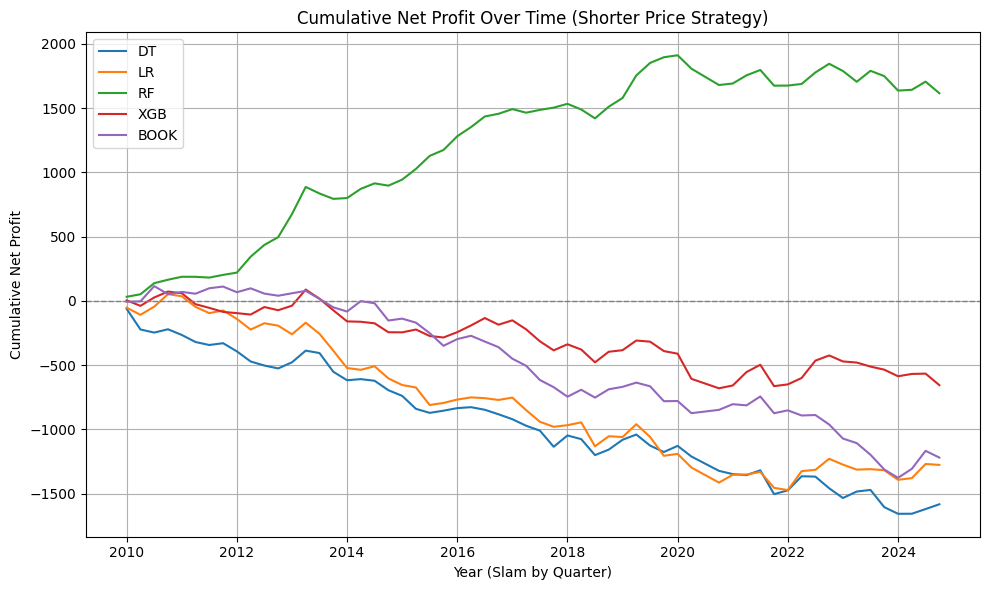

In [9]:
summary_sorted = summary.copy()
summary_sorted["Time"] = summary_sorted["Year"] + summary_sorted["Slam"].map({
    "Australian Open": 0.00,
    "Roland Garros": 0.25,
    "Wimbledon": 0.50,
    "US Open": 0.75
})
summary_sorted = summary_sorted.sort_values("Time")

for model in ["DT", "LR", "RF", "XGB", "BOOK"]:
    summary_sorted[f"{model}_cumulative"] = summary_sorted[f"{model}_net"].cumsum()

plt.figure(figsize=(10, 6))
for model in ["DT", "LR", "RF", "XGB", "BOOK"]:
    plt.plot(summary_sorted["Time"], summary_sorted[f"{model}_cumulative"], label=model)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Year (Slam by Quarter)")
plt.ylabel("Cumulative Net Profit")
plt.title("Cumulative Net Profit Over Time (Shorter Price Strategy)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Threshold strategy

In [10]:
def thresh_edge_strategy(
    df: pd.DataFrame,
    model: str,
    *,
    book_label: str  = 'BOOK',
    odds_label: str  = 'Odds',
    threshold: float = 2.20,
    stake: float     = STAKE,
):

    m1, m2 = f'{model}_p1', f'{model}_p2',
    b1, b2 = f'{book_label}_p1', f'{book_label}_p2',
    o1, o2 = f'{odds_label}_p1', f'{odds_label}_p2',
    result_col = 'RESULT'

    bet_p1 = (df[o1] <= threshold) & (df[m1] > df[b1])
    bet_p2 = (df[o2] <= threshold) & (df[m2] > df[b2])

    stake_array  = bet_p1.astype(int) + bet_p2.astype(int)
    total_stake  = stake * stake_array.sum()

    profit = np.zeros(len(df))

    win_p1 = (df[result_col] == 1) & bet_p1
    lose_p1 = (df[result_col] == 0) & bet_p1
    profit += np.where(win_p1,  stake * (df[o1] - 1), 0)
    profit += np.where(lose_p1, -stake, 0)

    win_p2 = (df[result_col] == 0) & bet_p2
    lose_p2 = (df[result_col] == 1) & bet_p2
    profit += np.where(win_p2,   stake * (df[o2] - 1), 0)
    profit += np.where(lose_p2, -stake, 0)

    bets        = (bet_p1 | bet_p2).sum()
    correct     = (win_p1 | win_p2).sum()              
    accuracy    = correct / bets if bets else np.nan

    return pd.Series({
        "bets"        : stake_array.sum(),
        "stake_total" : total_stake,
        "net_profit"  : profit.sum(),
        "roi"         : profit.sum() / total_stake if total_stake else 0.0,
        "correct"     : correct,
        "accuracy"    : accuracy
    })


def run_all_slams_threshold(
    slam_dict: dict,
    *,
    threshold: float,
):
    
    records = []

    for (slam, yr), df in slam_dict.items():
        row = {
            "Slam"   : slam,
            "Year"   : yr,
        }

        for model in MODELS:
            res = thresh_edge_strategy(df, model, threshold=threshold)

            row[f'{model}_bets'] = res["bets"]
            row[f'{model}_net'] = res["net_profit"]
            row[f'{model}_roi'] = res["roi"]
            row[f'{model}_wins'] = res["correct"]
            row[f'{model}_acc'] = res["accuracy"]

        records.append(row)

    return pd.DataFrame(records)

In [11]:
thresholds = np.arange(1.01, 5.01, 0.01)  

results = []

for thr in thresholds:
    out = run_all_slams_threshold(all_slams, threshold=thr)

    for model in MODELS:
        bets = out[f"{model}_bets"].sum()
        wins = out[f"{model}_wins"].sum()
        net  = out[f"{model}_net"].sum()
        roi  = net / (bets * STAKE) if bets else 0
        acc  = wins / bets if bets else 0

        results.append({
            "threshold": thr,
            "model": model,
            "bets": bets,
            "wins": wins,
            "net": net,
            "roi": roi,
            "accuracy": acc
        })

results_df = pd.DataFrame(results)

In [12]:
top_by_roi = results_df.sort_values("roi", ascending=False)
top_by_roi["roi"] = top_by_roi["roi"].apply(lambda x: f"{x:.2%}")
top_by_roi["accuracy"] = top_by_roi["accuracy"].apply(lambda x: f"{x:.4f}")
display(top_by_roi.head(10))


top_by_net = results_df.sort_values("net", ascending=False)
top_by_net["roi"] = top_by_net["roi"].apply(lambda x: f"{x:.2%}")
top_by_net["accuracy"] = top_by_net["accuracy"].apply(lambda x: f"{x:.4f}")
display(top_by_net.head(10))

,threshold,model,bets,wins,net,roi,accuracy
352,1.71,RF,2045.0,1757.0,2113.1,10.33%,0.8592
347,1.70,RF,2034.0,1749.0,2086.3,10.26%,0.8599
357,1.72,RF,2075.0,1775.0,2122.7,10.23%,0.8554
372,1.75,RF,2148.0,1821.0,2195.6,10.22%,0.8478
362,1.73,RF,2087.0,1782.0,2123.8,10.18%,0.8539
422,1.85,RF,2293.0,1908.0,2326.1,10.14%,0.8321
377,1.76,RF,2153.0,1823.0,2180.8,10.13%,0.8467
382,1.77,RF,2163.0,1829.0,2187.0,10.11%,0.8456
532,2.07,RF,2603.0,2080.0,2617.6,10.06%,0.7991
537,2.08,RF,2613.0,2085.0,2621.6,10.03%,0.7979


,threshold,model,bets,wins,net,roi,accuracy
1482,3.97,RF,4882.0,2937.0,3578.5,7.33%,0.6016
1477,3.96,RF,4879.0,2936.0,3568.8,7.31%,0.6018
1472,3.95,RF,4879.0,2936.0,3568.8,7.31%,0.6018
1052,3.11,RF,4143.0,2727.0,3564.4,8.60%,0.6582
1487,3.98,RF,4884.0,2937.0,3558.5,7.29%,0.6014
1467,3.94,RF,4865.0,2932.0,3550.8,7.30%,0.6027
1512,4.03,RF,4981.0,2961.0,3549.2,7.13%,0.5945
1057,3.12,RF,4148.0,2728.0,3545.6,8.55%,0.6577
1072,3.15,RF,4186.0,2740.0,3543.4,8.46%,0.6546
1092,3.19,RF,4202.0,2745.0,3542.7,8.43%,0.6533


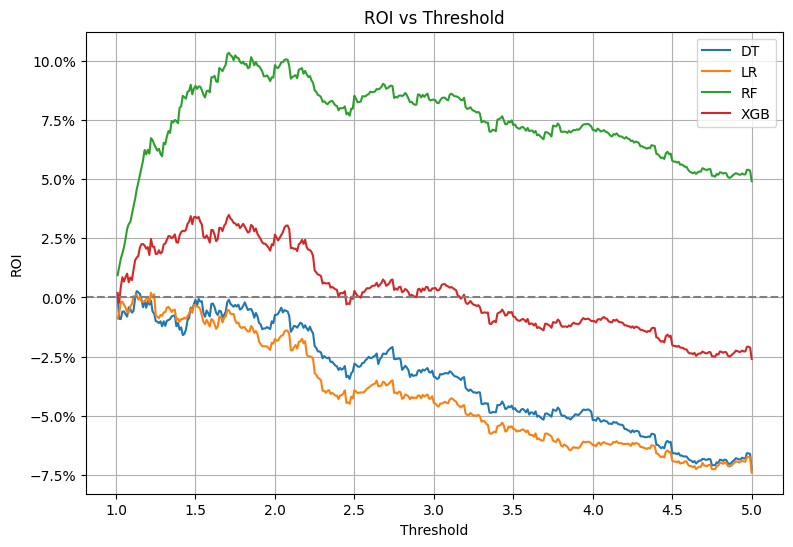

In [13]:
plt.figure(figsize=(9, 6))

for model in [m for m in MODELS if m != 'BOOK']:
    model_df = results_df[results_df["model"] == model]
    plt.plot(model_df["threshold"], model_df["roi"], label=model)

plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("ROI")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.title("ROI vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


## Model Agreement Strategy

In [14]:
def simulate_agreement_strategy(
    df: pd.DataFrame,
    *,
    models: list[str],
    stake: float = STAKE,
    threshold: float = 0.5,
    result_col: str = "RESULT"
):
    agree_p1 = np.ones(len(df), dtype=bool)
    agree_p2 = np.ones(len(df), dtype=bool)

    for model in models:
        agree_p1 &= df[f'{model}_p1'] > threshold
        agree_p2 &= df[f'{model}_p2'] > threshold

    bet_p1 = agree_p1
    bet_p2 = agree_p2
    stake_array = bet_p1.astype(int) + bet_p2.astype(int)
    total_stake = stake * stake_array.sum()

    profit = np.zeros(len(df))

    win_p1 = (df[result_col] == 1) & bet_p1
    lose_p1 = (df[result_col] == 0) & bet_p1
    profit += np.where(win_p1,  stake * (df['Odds_p1'] - 1), 0)
    profit += np.where(lose_p1, -stake, 0)

    win_p2 = (df[result_col] == 0) & bet_p2
    lose_p2 = (df[result_col] == 1) & bet_p2
    profit += np.where(win_p2,  stake * (df['Odds_p2'] - 1), 0)
    profit += np.where(lose_p2, -stake, 0)

    bets = stake_array.sum()
    correct = (win_p1 | win_p2).sum()
    accuracy = correct / bets if bets else np.nan

    return pd.Series({
        "bets"        : bets,
        "stake_total" : total_stake,
        "net_profit"  : profit.sum(),
        "roi"         : profit.sum() / total_stake if total_stake else 0.0,
        "correct"     : correct,
        "accuracy"    : accuracy
    })

def run_all_slams_agreement(
    slam_dict: dict,
    *,
    models: list[str],
    stake: float = STAKE,
    threshold: float = 0.5
):
    rows = []
    for (slam, yr), df in slam_dict.items():
        res = simulate_agreement_strategy(df, models=models, threshold=threshold, stake=stake)
        rows.append({
            "Slam"   : slam,
            "Year"   : yr,
            "bets"   : res["bets"],
            "net"    : res["net_profit"],
            "roi"    : res["roi"],
            "wins"   : res["correct"],
            "acc"    : res["accuracy"]
        })

    return pd.DataFrame(rows)

In [15]:
thresholds = np.arange(0.30, 0.81, 0.01)

model_sets = [
    ["RF", "XGB", 'LR'],
    ["LR", "XGB"],
    ["LR", "RF"],
    ["RF", "XGB"],
    ['LR'],
    ['XGB'],
    ['RF'],
]

all_results = []

for model_group in model_sets:
    group_name = "+".join(model_group)
    for thr in thresholds:
        out = run_all_slams_agreement(all_slams, models=model_group, stake=STAKE, threshold=thr)

        total_bets = out["bets"].sum()
        total_wins = out["wins"].sum()
        total_net = out["net"].sum()
        roi = total_net / (total_bets * STAKE) if total_bets else 0
        acc = total_wins / total_bets if total_bets else 0

        all_results.append({
            "models": group_name,
            "threshold": thr,
            "bets": total_bets,
            "wins": total_wins,
            "net": total_net,
            "roi": roi,
            "accuracy": acc
        })

all_results_df = pd.DataFrame(all_results)

In [16]:
all_results_df.sort_values(by='roi', ascending=False).head(15)

,models,threshold,bets,wins,net,roi,accuracy
347,RF,0.71,3571.0,3248.0,1540.96,0.043152,0.909549
352,RF,0.76,2647.0,2488.0,1139.86,0.043062,0.939932
353,RF,0.77,2482.0,2347.0,1056.66,0.042573,0.945608
351,RF,0.75,2851.0,2657.0,1208.16,0.042377,0.931954
350,RF,0.74,3034.0,2808.0,1265.66,0.041716,0.925511
348,RF,0.72,3387.0,3097.0,1412.76,0.041711,0.914379
354,RF,0.78,2324.0,2208.0,965.66,0.041552,0.950086
349,RF,0.73,3212.0,2952.0,1327.86,0.041341,0.919054
355,RF,0.79,2154.0,2058.0,883.56,0.041019,0.955432
346,RF,0.70,3744.0,3377.0,1509.06,0.040306,0.901976


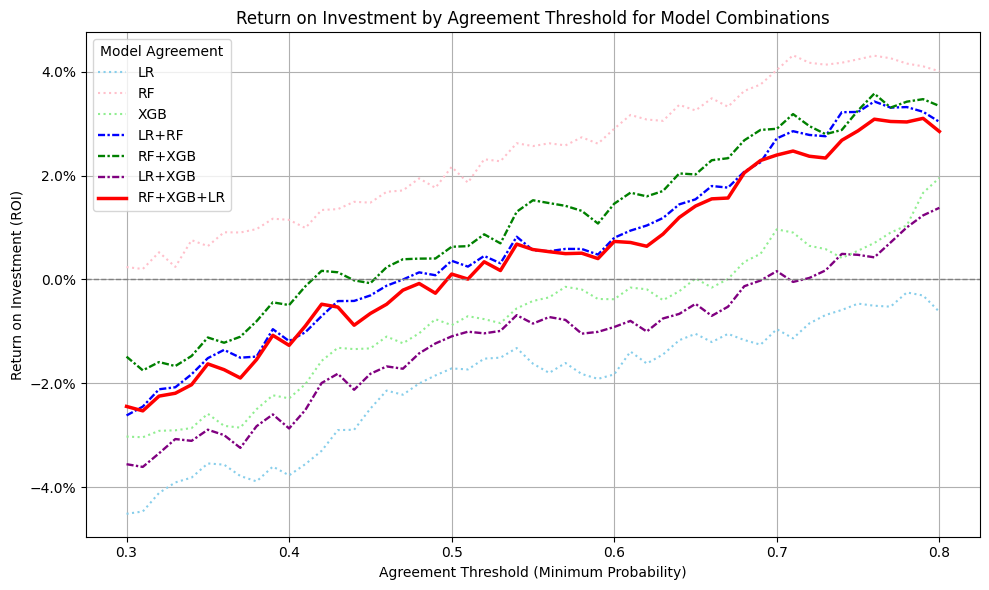

In [17]:
custom_order = [
    "LR",
    "RF",
    "XGB",
    "LR+RF",
    "RF+XGB",
    "LR+XGB",
    "RF+XGB+LR"
]

lines = {}
plt.figure(figsize=(10, 6))

for name, group in all_results_df.groupby("models"):
    if name == "RF+XGB+LR":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='red', linestyle='solid', linewidth=2.5)
    elif name == "LR+XGB":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='purple', linestyle=(0, (3, 1, 1, 1)), linewidth=1.7)
    elif name == "LR+RF":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='blue', linestyle=(0, (3, 1, 1, 1)), linewidth=1.7)
    elif name == "RF+XGB":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='green', linestyle=(0, (3, 1, 1, 1)), linewidth=1.7)
    elif name == "LR":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='skyblue', linestyle='dotted', linewidth=1.5)
    elif name == "XGB":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='lightgreen', linestyle='dotted', linewidth=1.5)
    elif name == "RF":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='pink', linestyle='dotted', linewidth=1.5)
    
    lines[name] = line

ordered_handles = [lines[name] for name in custom_order if name in lines]
ordered_labels = [name for name in custom_order if name in lines]

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Agreement Threshold (Minimum Probability)")
plt.ylabel("Return on Investment (ROI)")
plt.title("Return on Investment by Agreement Threshold for Model Combinations")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend(ordered_handles, ordered_labels, title="Model Agreement")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
model_sets = [
    ["DT", "LR"],
    ['DT'],
    ['LR']
]

all_results_2 = []

for model_group in model_sets:
    group_name = "+".join(model_group)
    for thr in thresholds:
        out = run_all_slams_agreement(all_slams, models=model_group, stake=STAKE, threshold=thr)

        total_bets = out["bets"].sum()
        total_wins = out["wins"].sum()
        total_net = out["net"].sum()
        roi = total_net / (total_bets * STAKE) if total_bets else 0
        acc = total_wins / total_bets if total_bets else 0

        all_results_2.append({
            "models": group_name,
            "threshold": thr,
            "bets": total_bets,
            "wins": total_wins,
            "net": total_net,
            "roi": roi,
            "accuracy": acc
        })

all_results_df_2 = pd.DataFrame(all_results_2)

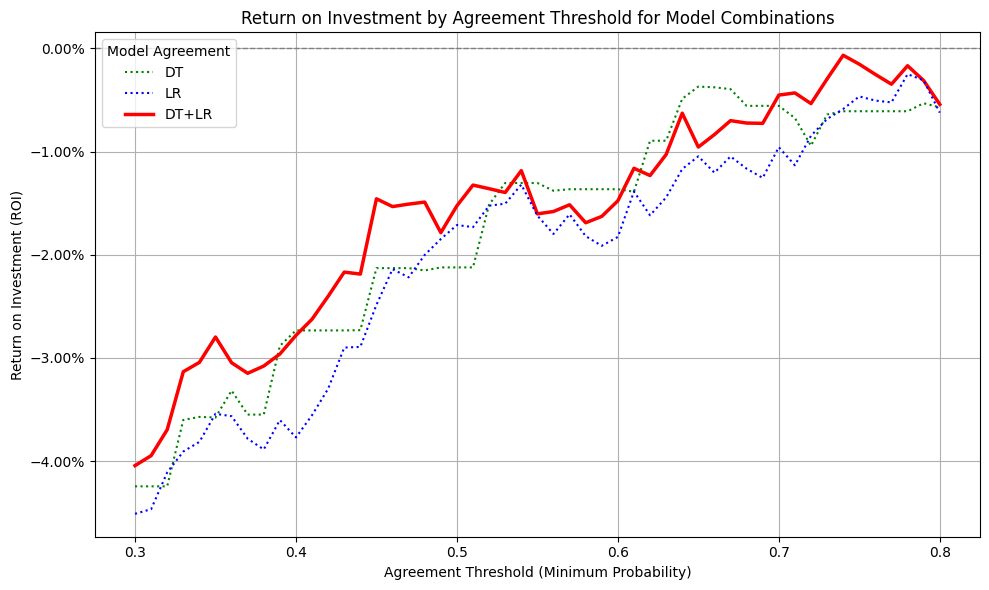

In [19]:
custom_order = ["DT", "LR", "DT+LR"]

lines = {}

plt.figure(figsize=(10, 6))

for name, group in all_results_df_2.groupby("models"):
    if name == "DT+LR":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='red', linestyle='solid', linewidth=2.5)
    elif name == "DT":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='green', linestyle='dotted', linewidth=1.5)
    elif name == "LR":
        line, = plt.plot(group["threshold"], group["roi"], label=name, color='blue', linestyle='dotted', linewidth=1.5)
    
    lines[name] = line

ordered_handles = [lines[name] for name in custom_order if name in lines]
ordered_labels = [name for name in custom_order if name in lines]

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Agreement Threshold (Minimum Probability)")
plt.ylabel("Return on Investment (ROI)")
plt.title("Return on Investment by Agreement Threshold for Model Combinations")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend(ordered_handles, ordered_labels, title="Model Agreement", loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()
